## **Table 57. Related dependencies for this chapter**

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import itertools
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Lambda, Flatten, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tabulate import tabulate
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas_datareader import data as pdr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from decimal import Decimal
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from graphviz import Digraph
!pip install arch --upgrade
import arch
from arch import arch_model
from sklearn.model_selection import TimeSeriesSplit
seed = 2025

## **Table 58. Data ingestion and log returns calculation**


In [ ]:
data = pd.read_csv('/content/Henry_Hub_Natural_Gas_Spot_Price.csv',
                   index_col=0,
                   skiprows=range(1, 6))

data.index = pd.to_datetime(data.index)
data = data[(data.index >= pd.to_datetime('2000-01-01')) & (data.index < pd.to_datetime('2025-01-01'))]
data = data.rename(columns={'Henry Hub Natural Gas Spot Price': 'NG'})
data = data.sort_index(ascending=True)
data.tail()

,NG
2024-12-24,2.95
2024-12-26,2.96
2024-12-27,2.91
2024-12-30,3.39
2024-12-31,3.40


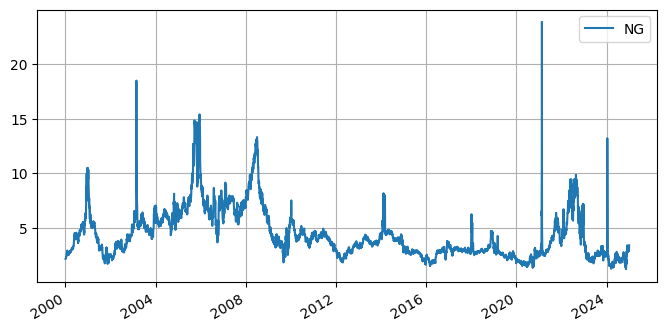

In [ ]:
data.plot(figsize = (8, 4))
plt.grid()
plt.show()

## **Table 59. Rolling Window Volatility calculation**

In [ ]:
window = 21
n_steps = 5

data['log_returns'] = (np.log(data/data.shift(1)))
data['vol_current'] = data.log_returns.rolling(window = window).std(ddof=1)
data['vol_future'] = data.log_returns.shift(-n_steps).rolling(window = window).std(ddof=1)
data.dropna(inplace = True)
data.describe()

,NG,log_returns,vol_current,vol_future
count,6230.000000,6.230000e+03,6230.000000,6230.000000
mean,4.332384,-5.243677e-07,0.044403,0.044409
std,2.208640,5.971668e-02,0.041147,0.041129
min,1.210000,-1.401562e+00,0.010054,0.010054
25%,2.760000,-2.179287e-02,0.023342,0.023342
50%,3.720000,0.000000e+00,0.034028,0.034057
75%,5.470000,2.042625e-02,0.051356,0.051458
max,23.860000,1.432814e+00,0.455035,0.455035


In [ ]:
print(data.head())

              NG  log_returns  vol_current  vol_future
2000-02-03  2.85    -0.020834     0.023580    0.031662
2000-02-04  2.78    -0.024868     0.024954    0.031711
2000-02-07  2.81     0.010734     0.024902    0.032011
2000-02-08  2.60    -0.077673     0.031686    0.031952
2000-02-09  2.62     0.007663     0.031676    0.031558


In [ ]:
print(data['vol_current'].max())
print(data['vol_current'].min())

0.4550350422379022
0.010054235786100032


In [ ]:
data.isnull().sum()

,0
NG,0
log_returns,0
vol_current,0
vol_future,0


## **Table 60. Unit root examination**

In [ ]:
adf_results = {
    'log_returns': adfuller(data['log_returns']),
    'vol_current': adfuller(data['vol_current']),
    'vol_future': adfuller(data['vol_future'])}

table_data = []
for column, result in adf_results.items():
    table_data.append([
        column,
        result[0],
        result[1],
        result[4]['1%'],
        result[4]['5%'],
        result[4]['10%']])

table = tabulate(table_data, headers=['Column', 'ADF Statistic', 'p-value', 'Critical Value (1%)', 'Critical Value (5%)', 'Critical Value (10%)'], tablefmt='fancy_grid')
print(table)

╒═════════════╤═════════════════╤═════════════╤═══════════════════════╤═══════════════════════╤════════════════════════╕
│ Column      │   ADF Statistic │     p-value │   Critical Value (1%) │   Critical Value (5%) │   Critical Value (10%) │
╞═════════════╪═════════════════╪═════════════╪═══════════════════════╪═══════════════════════╪════════════════════════╡
│ log_returns │       -17.7856  │ 3.2634e-30  │              -3.4314  │              -2.86201 │               -2.56702 │
├─────────────┼─────────────────┼─────────────┼───────────────────────┼───────────────────────┼────────────────────────┤
│ vol_current │        -8.5385  │ 9.92932e-14 │              -3.4314  │              -2.86201 │               -2.56702 │
├─────────────┼─────────────────┼─────────────┼───────────────────────┼───────────────────────┼────────────────────────┤
│ vol_future  │        -8.66696 │ 4.65625e-14 │              -3.43141 │              -2.86201 │               -2.56702 │
╘═════════════╧═════════════════

## **Table 61. Train-Test split**

In [ ]:
test_size = 0.2
total_len = len(data)
test_len = int(test_size * total_len)
train_len = total_len - test_len

train_index = data.index[:train_len]
test_index = data.index[train_len:]

table_data = [
    ["Training", f"{train_index[0]}", f"{train_index[-1]}", f"{len(train_index)} days"],
    ["Test", f"{test_index[0]}", f"{test_index[-1]}", f"{len(test_index)} days"],]

table = tabulate(table_data, headers=["Set", "From", "To", "Duration"], tablefmt="fancy_grid")
print(table)

╒══════════╤═════════════════════╤═════════════════════╤════════════╕
│ Set      │ From                │ To                  │ Duration   │
╞══════════╪═════════════════════╪═════════════════════╪════════════╡
│ Training │ 2000-02-03 00:00:00 │ 2020-01-03 00:00:00 │ 4984 days  │
├──────────┼─────────────────────┼─────────────────────┼────────────┤
│ Test     │ 2020-01-06 00:00:00 │ 2024-12-23 00:00:00 │ 1246 days  │
╘══════════╧═════════════════════╧═════════════════════╧════════════╛


## **Table 62. Customized Sliding window split**

In [ ]:
def sliding_window_split(data, window_size, step_size, min_test_size = 21):
    splits = []
    for i in range(0, len(data) - window_size + 1, step_size):
        train_idx = data.index[i : i + window_size]
        test_idx = data.index[i + window_size : min(i + window_size + step_size, len(data))]

        if len(test_idx) < min_test_size:
            continue

        splits.append((train_idx, test_idx))
    return splits

window_size = int(len(data) * 0.8)
step_size = int(len(data) * 0.04)

for fold, (train_idx, test_idx) in enumerate(sliding_window_split(data, window_size, step_size), 1):
    print(f"Fold {fold}:")
    print(f"Training period: {train_idx.min()} to {train_idx.max()}, {len(train_idx)} days")
    print(f"Testing period: {test_idx.min()} to {test_idx.max()}, {len(test_idx)} days")

Fold 1:
Training period: 2000-02-03 00:00:00 to 2020-01-03 00:00:00, 4984 days
Testing period: 2020-01-06 00:00:00 to 2020-12-30 00:00:00, 249 days
Fold 2:
Training period: 2001-02-01 00:00:00 to 2020-12-30 00:00:00, 4984 days
Testing period: 2020-12-31 00:00:00 to 2021-12-28 00:00:00, 249 days
Fold 3:
Training period: 2002-01-31 00:00:00 to 2021-12-28 00:00:00, 4984 days
Testing period: 2021-12-29 00:00:00 to 2022-12-23 00:00:00, 249 days
Fold 4:
Training period: 2003-01-30 00:00:00 to 2022-12-23 00:00:00, 4984 days
Testing period: 2022-12-27 00:00:00 to 2023-12-22 00:00:00, 249 days
Fold 5:
Training period: 2004-01-30 00:00:00 to 2023-12-22 00:00:00, 4984 days
Testing period: 2023-12-26 00:00:00 to 2024-12-20 00:00:00, 249 days


## **Table 63. Baseline models**

In [ ]:
scaler = MinMaxScaler()

results = []
for fold, (train_idx, test_idx) in enumerate(sliding_window_split(data, window_size, step_size), 1):
    train_data = data.loc[train_idx]
    test_data = data.loc[test_idx]

    X_train = train_data['vol_current'].values.reshape(-1, 1)
    y_train = train_data['vol_future'].values
    X_test = test_data['vol_current'].values.reshape(-1, 1)
    y_test = test_data['vol_future'].values

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    baseline_pred = np.mean(y_train)
    baseline_pred = np.full_like(y_test, baseline_pred)
    random_walk_pred = X_test[:, 0]

    results.append({
        'Fold': fold,
        'Model': 'Baseline',
        'RMSE': np.sqrt(mean_squared_error(y_test, baseline_pred.flatten())),
        'RMSPE': np.sqrt(np.mean(((y_test - baseline_pred.flatten()) / y_test) ** 2)) * 100})

    results.append({
        'Fold': fold,
        'Model': 'Random Walk',
        'RMSE': np.sqrt(mean_squared_error(y_test, random_walk_pred.flatten())),
        'RMSPE': np.sqrt(np.mean(((y_test - random_walk_pred.flatten()) / y_test) ** 2)) * 100})


results_df = pd.DataFrame(results)
avg_results = results_df.groupby('Model')[['RMSE', 'RMSPE']].mean().reset_index()
print(avg_results)

         Model      RMSE      RMSPE
0     Baseline  0.068855  46.091674
1  Random Walk  0.034481  52.148939


In [ ]:
diagram = Digraph(format='png', engine='dot')

# Neural Network
diagram.attr(label="Neural Network Structure", labelloc="t", fontsize="20", fontcolor="blue")
diagram.node("Input", "Input Layer", shape="circle", style="filled", fillcolor="lightblue")
diagram.node("Hidden1", "Hidden Layer 1", shape="circle", style="filled", fillcolor="lightgreen")
diagram.node("Hidden2", "Hidden Layer 2", shape="circle", style="filled", fillcolor="lightgreen")
diagram.node("Output", "Output Layer", shape="circle", style="filled", fillcolor="lightcoral")

diagram.edges([("Input", "Hidden1"), ("Hidden1", "Hidden2"), ("Hidden2", "Output")])
# LSTM
diagram.attr(label="LSTM Structure", labelloc="t", fontsize="20", fontcolor="blue")
diagram.node("Input_LSTM", "Input Sequence", shape="ellipse", style="filled", fillcolor="lightyellow")
diagram.node("Forget", "Forget Gate", shape="parallelogram", style="filled", fillcolor="orange")
diagram.node("Input_Gate", "Input Gate", shape="parallelogram", style="filled", fillcolor="orange")
diagram.node("Cell", "Memory Cell", shape="diamond", style="filled", fillcolor="pink")
diagram.node("Output_LSTM", "Output Gate", shape="parallelogram", style="filled", fillcolor="orange")
diagram.node("Hidden_State", "Hidden State", shape="ellipse", style="filled", fillcolor="lightcyan")

diagram.edges([
    ("Input_LSTM", "Forget"),
    ("Input_LSTM", "Input_Gate"),
    ("Forget", "Cell"),
    ("Input_Gate", "Cell"),
    ("Cell", "Output_LSTM"),
    ("Output_LSTM", "Hidden_State")])

diagram.render("Neural_Network_LSTM_Workflow", view=True)

## **Table 64. Windowed and plot functions**

In [ ]:
def windowed_dataset(x_series, y_series, lookback_window):
    x_series = np.array(x_series)
    y_series = np.array(y_series)

    dataX, dataY = [], []
    for i in range(lookback_window, len(x_series)):
        dataX.append(x_series[i - lookback_window:i])
        dataY.append(y_series[i])
    return np.array(dataX), np.array(dataY)

def plot(model_hist):
    plt.figure(figsize = (8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(model_hist['loss'], label = 'Training Loss (MSE)')
    plt.plot(model_hist['val_loss'], label = 'Test Loss (MSE)')
    plt.title('Training and Test MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(model_hist['rmspe'], label = 'Training RMSPE')
    plt.plot(model_hist['val_rmspe'], label = 'Test RMSPE')
    plt.title('Training and Test RMSPE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSPE')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

## **Table 65. Setting up a Single-Layer Fully Connected Neural Network**

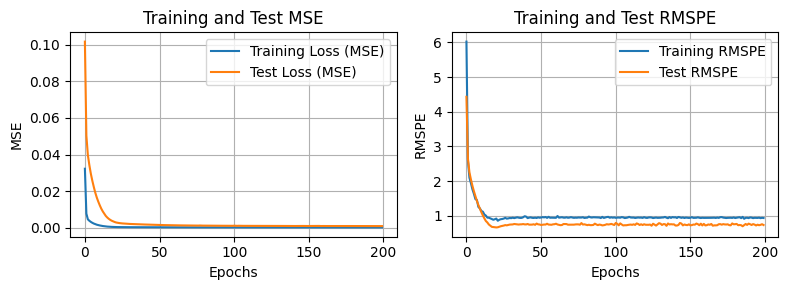

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(seed)

n_steps = 21
batch_size = 64
epochs = 200
val_split = 0.2

xTrain_windowed, yTrain_windowed = windowed_dataset(X_train_scaled, y_train, n_steps)

simpleNN = Sequential([
    Flatten(input_shape = [n_steps, 1]),
    Dense(1)])

simpleNN.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = [rmspe])

early_stopping = EarlyStopping(patience = 10,
                               restore_best_weights = True,
                               monitor = 'test_rmspe',
                               mode = 'min')

result = simpleNN.fit(
    xTrain_windowed,
    yTrain_windowed,
    epochs = epochs,
    validation_split = val_split,
    verbose = 0,
    batch_size = batch_size,
    callbacks = [early_stopping],
    shuffle = True)

history = result.history
plot(history)

In [ ]:
xTest_windowed, yTest_windowed = windowed_dataset(X_test_scaled, y_test, n_steps)
predictions = simpleNN.predict(xTest_windowed)

mse = mean_squared_error(yTest_windowed, predictions.flatten())
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean(((yTest_windowed - predictions.flatten()) / yTest_windowed) ** 2)) * 100

results_df = pd.DataFrame({
    'Model': ['Simple NN'],
    'RMSE': [rmse],
    'RMSPE': [rmspe]})

print(results_df)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
       Model      RMSE      RMSPE
0  Simple NN  0.049215  73.729462


## **Table 66. Initializing and configuring an LSTM-based neural network**

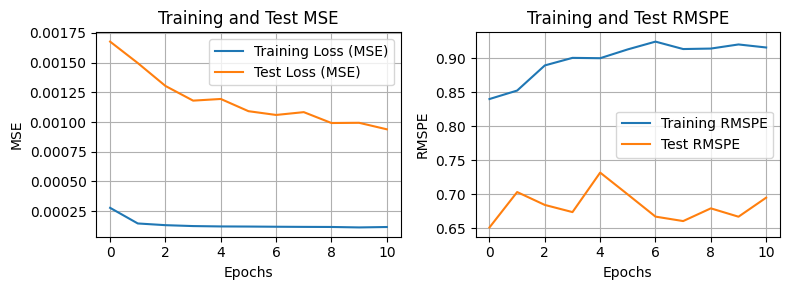

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
   Model      RMSE      RMSPE
0  lstmA  0.065504  99.910129


In [ ]:
tf.keras.backend.clear_session()
np.random.seed(seed)

def rmspe(yTrue, yPred):
       return K.sqrt(K.mean(K.square((yTrue - yPred) / (yTrue + K.epsilon()))))

lstmA = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis = -1),
                           input_shape = [None]),
    LSTM(20),
    Dense(1)])

lstmA.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = [rmspe])

checkpoint = ModelCheckpoint('lstmA.keras',
                             save_best_only = True,
                             monitor = 'val_rmspe')

early_stopping = EarlyStopping(patience = 10,
                               restore_best_weights = True,
                               monitor = 'val_rmspe',
                               mode = 'min')

lstmA_res = lstmA.fit(xTrain_windowed,
                        yTrain_windowed,
                        callbacks = [checkpoint, early_stopping],
                        validation_split = val_split,
                        shuffle = True,
                        verbose = 0,
                        batch_size = batch_size,
                        epochs = epochs)

history = lstmA_res.history
plot(history)

xTest_windowed, yTest_windowed = windowed_dataset(X_test_scaled, y_test, n_steps)
predictions = lstmA.predict(xTest_windowed)
mse = mean_squared_error(yTest_windowed, predictions.flatten())
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean(((yTest_windowed - predictions.flatten()) / yTest_windowed) ** 2)) * 100

results_df = pd.DataFrame({
    'Model': ['lstmA'],
    'RMSE': [rmse],
    'RMSPE': [rmspe]})

print(results_df)

## **Table 67. Bidirectional LSTM**

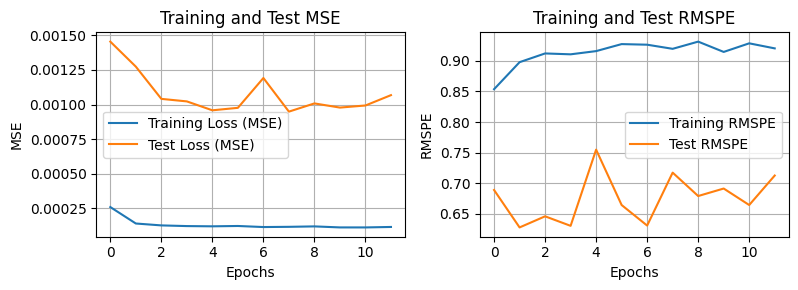

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
        Model      RMSE      RMSPE
0  BiDir_LSTM  0.053216  71.322845


In [ ]:
tf.keras.backend.clear_session()
np.random.seed(seed)

def rmspe(yTrue, yPred):
    return K.sqrt(K.mean(K.square((yTrue - yPred) / yTrue)))

bidir_lstm = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis = -1),
                           input_shape = [None]),
    Bidirectional(LSTM(32, return_sequences = True)),
    Bidirectional(LSTM(16)),
    Dense(1)])

bidir_lstm.compile(loss = 'mse',
               optimizer = "adam",
               metrics = [rmspe])

checkpoint = ModelCheckpoint('lstm_1.keras',
                             save_best_only=True,
                             monitor = 'val_rmspe')

early_stopping = EarlyStopping(patience=10,
                               restore_best_weights = True,
                               monitor = 'val_rmspe',
                               mode = 'min')

bidir_lstm_res = bidir_lstm.fit(xTrain_windowed,
                        yTrain_windowed,
                        callbacks = [checkpoint, early_stopping],
                        validation_split = val_split,
                        shuffle = True,
                        verbose = 0,
                        batch_size = batch_size,
                        epochs = epochs)

history = bidir_lstm_res.history
plot(history)

xTest_windowed, yTest_windowed = windowed_dataset(X_test_scaled, y_test, n_steps)
predictions = bidir_lstm.predict(xTest_windowed)
mse = mean_squared_error(yTest_windowed, predictions.flatten())
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean(((yTest_windowed - predictions.flatten()) / yTest_windowed) ** 2)) * 100

results_df = pd.DataFrame({
    'Model': ['BiDir_LSTM'],
    'RMSE': [rmse],
    'RMSPE': [rmspe]})

print(results_df)

## **Table 68. LSTM with SGD optimizer**

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(seed)

def rmspe(yTrue, yPred):
    return K.sqrt(K.mean(K.square((yTrue - yPred) / yTrue)))

lstmSGD = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis = -1),
                           input_shape = [None]),
    Bidirectional(LSTM(32, return_sequences = True)),
    Bidirectional(LSTM(16)),
    Dense(1)])

learning_rate_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 50))

optimizer = SGD(learning_rate = 1e-6,
                momentum = 0.9)
lstmSGD.compile(loss = 'mse',
                optimizer = optimizer,
                metrics = [rmspe])

lstmSGD_res = lstmSGD.fit(
    xTrain_windowed,
    yTrain_windowed,
    epochs = epochs,
    callbacks = [learning_rate_schedule],
    validation_split = val_split,
    verbose = 0,
    batch_size = batch_size,
    shuffle = True)

training_loss = lstmSGD_res.history['loss']
validation_loss = lstmSGD_res.history['val_loss']
learning_rates = [1e-6 * 10**(epoch / 50) for epoch in range(len(training_loss))]
best_epoch = np.argmin(validation_loss)
best_learning_rate = learning_rates[best_epoch]
print(f"Best Learning Rate: {best_learning_rate}")

Best Learning Rate: 0.008709635899560806


## **Table 69. LSTM model with SGD optimizer and best learning rate**

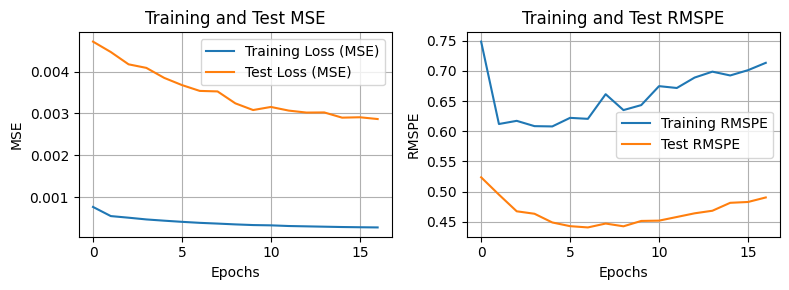

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step
         Model      RMSE      RMSPE
0  LSTMSGD_blr  0.093057  53.167148


In [ ]:
tf.keras.backend.clear_session()
np.random.seed(seed)

def rmspe(yTrue, yPred):
    return K.sqrt(K.mean(K.square((yTrue - yPred) / yTrue)))

lstmSGD_blr = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis = -1),
                           input_shape = [None]),
    Bidirectional(LSTM(32, return_sequences = True)),
    Bidirectional(LSTM(16)),
    Dense(1)])

optimizer = SGD(best_learning_rate, momentum = 0.9)
lstmSGD_blr.compile(loss='mse',
                    optimizer = optimizer,
                    metrics = [rmspe])

checkpoint = ModelCheckpoint('lstm_4.keras',
                             save_best_only = True,
                             monitor = 'val_rmspe')

early_stopping = EarlyStopping(patience = 10,
                               restore_best_weights=True,
                               monitor = 'val_rmspe',
                               mode = 'min')

lstmSGD_blr_res = lstmSGD_blr.fit(xTrain_windowed,
                        yTrain_windowed,
                        epochs = epochs,
                        callbacks = [checkpoint, early_stopping],
                        validation_split = val_split,
                        verbose = 0,
                        batch_size = batch_size,
                        shuffle = True)

history = lstmSGD_blr_res.history
plot(history)

xTest_windowed, yTest_windowed = windowed_dataset(X_test, y_test, n_steps)
predictions = lstmSGD_blr.predict(xTest_windowed)

mse = mean_squared_error(yTest_windowed, predictions.flatten())
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean(((yTest_windowed - predictions.flatten()) / yTest_windowed) ** 2)) * 100

results_df = pd.DataFrame({
    'Model': ['LSTMSGD_blr'],
    'RMSE': [rmse],
    'RMSPE': [rmspe]})
print(results_df)

## **Table 70. Gated Recurrent Unit compilation**

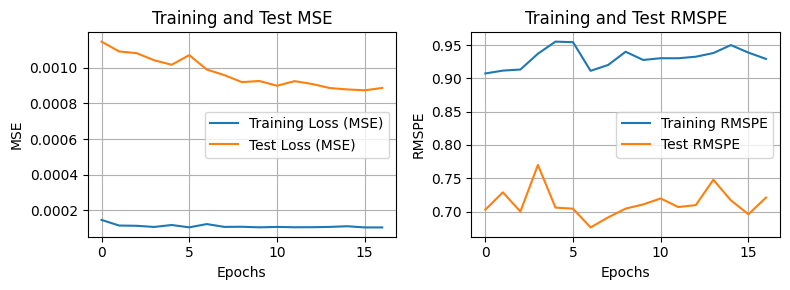

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
  Model      RMSE     RMSPE
0   GRU  0.053686  77.67209


In [ ]:
tf.keras.backend.clear_session()
np.random.seed(seed)

def rmspe(yTrue, yPred):
    return K.sqrt(K.mean(K.square((yTrue - yPred) / yTrue)))

gru_model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    GRU(32),
    Dense(1)])

gru_model.compile(loss = 'mse',
                  optimizer = 'adam',
                  metrics = [rmspe])

checkpoint = ModelCheckpoint('gru_model.keras',
                             save_best_only = True,
                             monitor = 'val_rmspe')
early_stopping = EarlyStopping(patience = 10,
                               restore_best_weights=True,
                               monitor = 'val_rmspe',
                               mode = 'min')

gru_res = gru_model.fit(
    xTrain_windowed,
    yTrain_windowed,
    epochs = epochs,
    callbacks = [checkpoint, early_stopping],
    validation_split = val_split,
    verbose = 0,
    batch_size = batch_size,
    shuffle = True)

history = gru_res.history
plot(history)

xTest_windowed, yTest_windowed = windowed_dataset(X_test_scaled, y_test, n_steps)
predictions = gru_model.predict(xTest_windowed)
mse = mean_squared_error(yTest_windowed, predictions.flatten())
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean(((yTest_windowed - predictions.flatten()) / yTest_windowed) ** 2)) * 100

results_df = pd.DataFrame({
    'Model': ['GRU'],
    'RMSE': [rmse],
    'RMSPE': [rmspe]})

print(results_df)

## **Table 71.GARCH model with current data**

In [ ]:
data = pd.read_csv('/content/Henry_Hub_Natural_Gas_Spot_Price.csv',
                   index_col=0, skiprows=range(1, 6))
data.index = pd.to_datetime(data.index)
data = data[(data.index >= pd.to_datetime('2000-01-01')) & (data.index < pd.to_datetime('2025-01-01'))]
data = data.rename(columns={'Henry Hub Natural Gas Spot Price': 'NG'})
data = data.sort_index(ascending=True)

window = 21
n_steps = 5
data['log_returns'] = np.log(data['NG'] / data['NG'].shift(1))
data['vol_current'] = data.log_returns.rolling(window = window).std(ddof=1)
data['vol_future'] = data.log_returns.shift(-n_steps).rolling(window = window).std(ddof=1)
data.dropna(inplace = True)

# Fit GARCH model on log returns
garch_model = arch_model(data['log_returns'], vol='Garch', p=1, q=1)
garch_results = garch_model.fit(disp='off')
data['garch_vol'] = garch_results.conditional_volatility
data.dropna(inplace=True)

## **Table 72. Combining GARCH volatility with current data using a simple Neural Network**

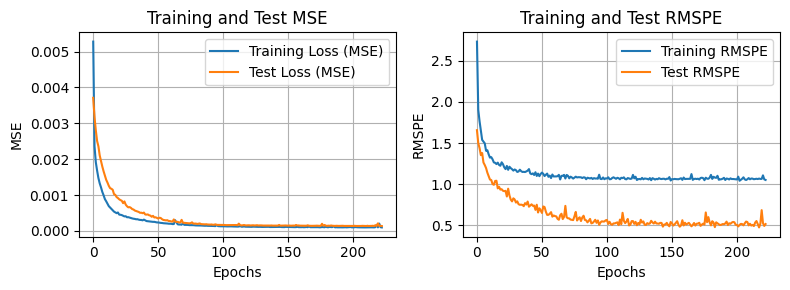

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
     Model      RMSE      RMSPE
0  GarchNN  0.037597  36.345678


In [ ]:
tf.keras.backend.clear_session()
np.random.seed(seed)

def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred) / K.clip(y_true, K.epsilon(), None))))

def windowed_dataset(X, y, window_size):
    X_windowed, y_windowed = [], []
    for i in range(window_size, len(X)):
        X_windowed.append(X[i - window_size:i])
        y_windowed.append(y[i])
    return np.array(X_windowed), np.array(y_windowed)

def plot(model_hist):
    plt.figure(figsize = (8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(model_hist['loss'], label = 'Training Loss (MSE)')
    plt.plot(model_hist['val_loss'], label = 'Test Loss (MSE)')
    plt.title('Training and Test MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(model_hist['rmspe'], label = 'Training RMSPE')
    plt.plot(model_hist['val_rmspe'], label = 'Test RMSPE')
    plt.title('Training and Test RMSPE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSPE')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

features = ['vol_current', 'garch_vol']
X = data[features].values
y = data['vol_future'].values

split_index = int(len(data) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

window_size = 21
X_train_windowed, y_train_windowed = windowed_dataset(X_train_scaled, y_train, window_size)
X_test_windowed, y_test_windowed = windowed_dataset(X_test_scaled, y_test, window_size)

model = Sequential([
    Flatten(input_shape=(window_size, X_train_windowed.shape[2])),
    Dense(1)])

model.compile(loss='mse', optimizer='adam', metrics=[rmspe])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_windowed, y_train_windowed,
    epochs=500,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0)

history = history.history
plot(history)

predictions = model.predict(X_test_windowed)
mse = mean_squared_error(y_test_windowed, predictions.flatten())
rmse = np.sqrt(mse)
rmspe_value = np.sqrt(np.mean(((y_test_windowed - predictions.flatten()) / y_test_windowed) ** 2)) * 100

results_df = pd.DataFrame({
    'Model': ['GarchNN'],
    'RMSE': [rmse],
    'RMSPE': [rmspe_value]})
print(results_df)

## **Table 74. Actual vs. predicted volatility using GARCH-NN**

R-squared: 0.7197204310974596


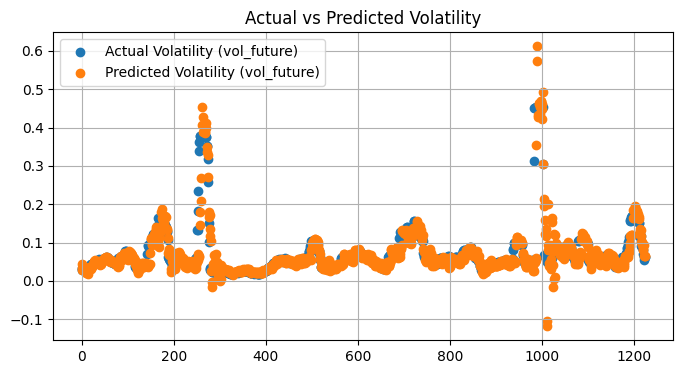

In [ ]:
r2 = r2_score(y_test_windowed, predictions.flatten())
print(f"R-squared: {r2}")

plt.figure(figsize=(8, 4))
plt.scatter(range(len(y_test_windowed)), y_test_windowed, label = 'Actual Volatility (vol_future)')
plt.scatter(range(len(predictions.flatten())), predictions.flatten(), label = 'Predicted Volatility (vol_future)')
plt.legend()
plt.title("Actual vs Predicted Volatility")
plt.grid()
plt.show()

## **Table 75. Predictions made by the model**

In [ ]:
for ind, i in enumerate(predictions):
    prediction_percentage = 100 * i[0]
    actual_percentage = 100 * y_test_windowed[ind]

    print(f"Prediction: {prediction_percentage:.2f}%,    Actual Value: {actual_percentage:.2f}%")

Prediction: 4.49%,    Actual Value: 3.45%
Prediction: 3.41%,    Actual Value: 3.21%
Prediction: 2.76%,    Actual Value: 2.88%
Prediction: 3.00%,    Actual Value: 3.09%
Prediction: 3.30%,    Actual Value: 3.10%
Prediction: 3.20%,    Actual Value: 2.96%
Prediction: 2.74%,    Actual Value: 2.78%
Prediction: 2.60%,    Actual Value: 2.70%
Prediction: 3.33%,    Actual Value: 2.67%
Prediction: 3.02%,    Actual Value: 2.31%
Prediction: 2.09%,    Actual Value: 3.03%
Prediction: 2.77%,    Actual Value: 3.03%
Prediction: 2.87%,    Actual Value: 3.05%
Prediction: 1.83%,    Actual Value: 3.07%
Prediction: 2.81%,    Actual Value: 3.15%
Prediction: 2.77%,    Actual Value: 3.23%
Prediction: 2.83%,    Actual Value: 3.59%
Prediction: 3.74%,    Actual Value: 3.58%
Prediction: 3.64%,    Actual Value: 4.07%
Prediction: 3.49%,    Actual Value: 3.99%
Prediction: 3.50%,    Actual Value: 4.33%
Prediction: 3.20%,    Actual Value: 4.50%
Prediction: 3.57%,    Actual Value: 4.52%
Prediction: 3.78%,    Actual Value